In [36]:
!pip install pyomo
!apt-get install -y coinor-cbc

import pyomo.environ as pyo


# Facilities and Customers
Facilities = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
Customers  = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']

# Facility opening costs
open_cost = {
    'F1': 70,
    'F2': 75,
    'F3': 80,
    'F4': 90,
    'F5': 72,
    'F6': 88
}


# Distance matrix (customer → facility)
distance = {


    ('C3','F1'): 14, ('C3','F2'): 60, ('C3','F3'): 42, ('C3','F4'): 75, ('C3','F5'): 48, ('C3','F6'): 70,
    ('C8','F1'): 16, ('C8','F2'): 62, ('C8','F3'): 45, ('C8','F4'): 78, ('C8','F5'): 50, ('C8','F6'): 72,
    ('C1','F1'): 18, ('C1','F2'): 65, ('C1','F3'): 47, ('C1','F4'): 80, ('C1','F5'): 52, ('C1','F6'): 75,
    ('C2','F1'): 46, ('C2','F2'): 68, ('C2','F3'): 15, ('C2','F4'): 70, ('C2','F5'): 44, ('C2','F6'): 73,
    ('C4','F1'): 48, ('C4','F2'): 70, ('C4','F3'): 17, ('C4','F4'): 72, ('C4','F5'): 46, ('C4','F6'): 75,
    ('C6','F1'): 45, ('C6','F2'): 67, ('C6','F3'): 19, ('C6','F4'): 74, ('C6','F5'): 43, ('C6','F6'): 71,
    ('C9','F1'): 47, ('C9','F2'): 69, ('C9','F3'): 16, ('C9','F4'): 73, ('C9','F5'): 45, ('C9','F6'): 74,
    ('C10','F1'): 44, ('C10','F2'): 66, ('C10','F3'): 49, ('C10','F4'): 76, ('C10','F5'): 14, ('C10','F6'): 72,
    ('C5','F1'): 46, ('C5','F2'): 68, ('C5','F3'): 52, ('C5','F4'): 78, ('C5','F5'): 16, ('C5','F6'): 74,
    ('C7','F1'): 43, ('C7','F2'): 65, ('C7','F3'): 48, ('C7','F4'): 75, ('C7','F5'): 18, ('C7','F6'): 70,
}




# ----------------------------
# Model Setup
# ----------------------------

model = pyo.ConcreteModel()

model.F = pyo.Set(initialize=Facilities)
model.C = pyo.Set(initialize=Customers)

# Decision variables
model.y = pyo.Var(model.F, domain=pyo.Binary)
model.x = pyo.Var(model.C, model.F, domain=pyo.Binary)

# Objective: minimize fixed costs + assignment distances
model.obj = pyo.Objective(
    expr=sum(open_cost[f] * model.y[f] for f in model.F) +
         sum(distance[c,f] * model.x[c,f] for c in model.C for f in model.F),
    sense=pyo.minimize
)

# Constraint: each customer assigned to exactly one facility
def one_facility_rule(model, c):
    return sum(model.x[c,f] for f in model.F) == 1
model.assign_rule = pyo.Constraint(model.C, rule=one_facility_rule)

# Constraint: customers assigned only if facility is open
def open_facility_rule(model, c, f):
    return model.x[c,f] <= model.y[f]
model.open_rule = pyo.Constraint(model.C, model.F, rule=open_facility_rule)

# Solve
solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
result = solver.solve(model, tee=False)

# Results

print("\nOptimal Facilities to Open:")
for f in model.F:
    if pyo.value(model.y[f]) > 0.5:
        print("  -", f)

print("\nCustomer Assignments:")
for c in model.C:
    for f in model.F:
        if pyo.value(model.x[c,f]) > 0.5:
            print(f"  {c} --> {f}")

print("\nTotal Opening Cost:", pyo.value(model.obj), "thousand")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-cbc is already the newest version (2.10.7+ds1-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.

Optimal Facilities to Open:
  - F1
  - F3
  - F5

Customer Assignments:
  C1 --> F1
  C2 --> F3
  C3 --> F1
  C4 --> F3
  C5 --> F5
  C6 --> F3
  C7 --> F5
  C8 --> F1
  C9 --> F3
  C10 --> F5

Total Opening Cost: 385.0 thousand


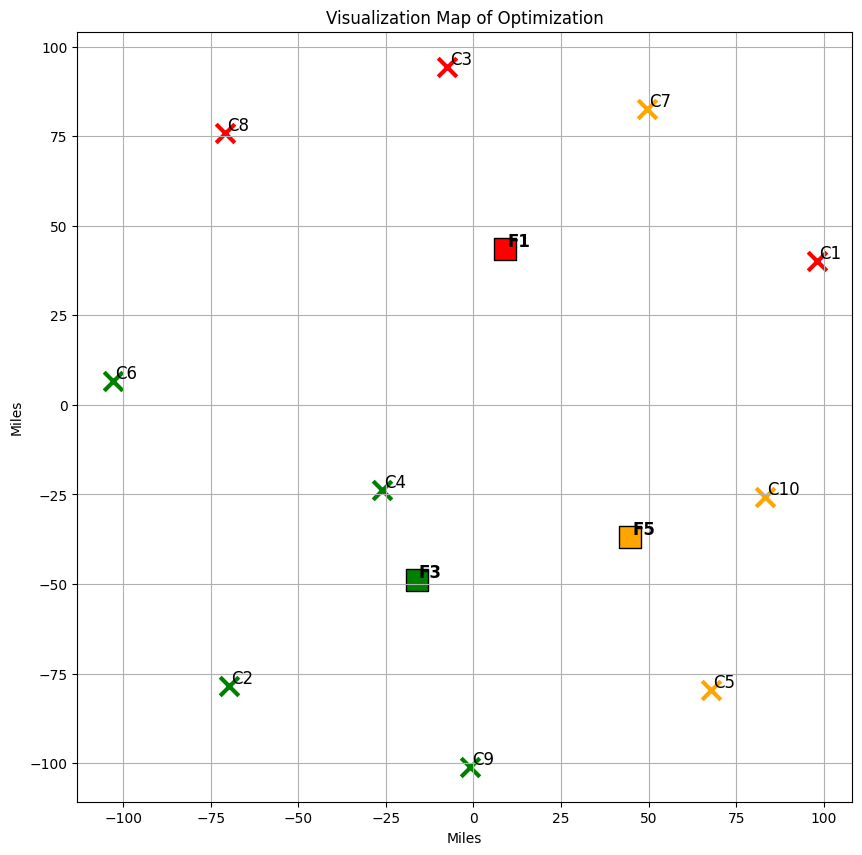

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Facilities and Customers
Facilities = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
Customers  = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

# Facilities you want to SHOW
Shown_Facilities = ['F1', 'F3', 'F5']

# Distance matrix (customer → facility)
distance = {


    ('C3','F1'): 14, ('C3','F2'): 60, ('C3','F3'): 42, ('C3','F4'): 75, ('C3','F5'): 48, ('C3','F6'): 70,
    ('C8','F1'): 16, ('C8','F2'): 62, ('C8','F3'): 45, ('C8','F4'): 78, ('C8','F5'): 50, ('C8','F6'): 72,
    ('C1','F1'): 18, ('C1','F2'): 65, ('C1','F3'): 47, ('C1','F4'): 80, ('C1','F5'): 52, ('C1','F6'): 75,
    ('C2','F1'): 46, ('C2','F2'): 68, ('C2','F3'): 15, ('C2','F4'): 70, ('C2','F5'): 44, ('C2','F6'): 73,
    ('C4','F1'): 48, ('C4','F2'): 70, ('C4','F3'): 17, ('C4','F4'): 72, ('C4','F5'): 46, ('C4','F6'): 75,
    ('C6','F1'): 45, ('C6','F2'): 67, ('C6','F3'): 19, ('C6','F4'): 74, ('C6','F5'): 43, ('C6','F6'): 71,
    ('C9','F1'): 47, ('C9','F2'): 69, ('C9','F3'): 16, ('C9','F4'): 73, ('C9','F5'): 45, ('C9','F6'): 74,
    ('C10','F1'): 44, ('C10','F2'): 66, ('C10','F3'): 49, ('C10','F4'): 76, ('C10','F5'): 14, ('C10','F6'): 72,
    ('C5','F1'): 46, ('C5','F2'): 68, ('C5','F3'): 52, ('C5','F4'): 78, ('C5','F5'): 16, ('C5','F6'): 74,
    ('C7','F1'): 43, ('C7','F2'): 65, ('C7','F3'): 48, ('C7','F4'): 75, ('C7','F5'): 18, ('C7','F6'): 70,
}


# Combine entities (unchanged for MDS geometry)
entities = Facilities + Customers
n = len(entities)

# Build MDS distance matrix
BIG = 200
D = np.zeros((n,n))

for i,e1 in enumerate(entities):
    for j,e2 in enumerate(entities):
        if e1 == e2:
            D[i,j] = 0
        elif e1 in Customers and e2 in Facilities:
            D[i,j] = distance[(e1,e2)]
        elif e2 in Customers and e1 in Facilities:
            D[i,j] = distance[(e2,e1)]
        else:
            D[i,j] = BIG

# Run MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(D)

# Reassign customers ONLY among shown facilities
assignments = {}
for c in Customers:
    best_f = min(Shown_Facilities, key=lambda f: distance[(c,f)])
    assignments[c] = best_f

# Color palette
colors = {
    'F1': 'red',
    'F3': 'green',
    'F5': 'orange'
}

# Plotting
plt.figure(figsize=(10,10))

# Plot ONLY selected facilities
for f in Shown_Facilities:
    idx = entities.index(f)
    x,y = coords[idx]
    plt.scatter(x,y, s=250, marker='s', color=colors[f], edgecolor='black')
    plt.text(x+0.7, y+0.7, f, fontsize=12, fontweight='bold')

# Plot customers colored by reassigned facility
for c in Customers:
    idx = entities.index(c)
    x,y = coords[idx]
    assigned_f = assignments[c]
    plt.scatter(x,y, s=180, marker='x', color=colors[assigned_f], linewidth=3)
    plt.text(x+0.7, y+0.7, c, fontsize=12)

plt.title("Visualization Map of Optimization")
plt.xlabel("Miles")
plt.ylabel("Miles")
plt.grid(True)
plt.show()

